In [63]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2 as cv
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from data_process import (add_noise, create_data, flip, greyscale,
                          normalization, rotate, process)

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [65]:
train_path = 'dataset/training_data_aug'
test_path = 'dataset/testing_data'

In [66]:
BATCH_SIZE =32

In [116]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ])

train_data = torchvision.datasets.ImageFolder(root=train_path, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = torchvision.datasets.ImageFolder(root=test_path, transform=TRANSFORM_IMG)
test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True) 

tensor(0)


AttributeError: 'AxesImage' object has no property 'normalize'

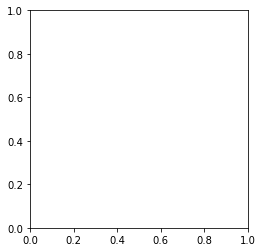

In [118]:
images, labels = next(test_data_loader.__iter__())
# helper.imshow(images[0], normalize=False)
print(labels[0])
#plt.imshow(np.reshape(images[0],(224,224,3)))
plt.imshow(images[0], normalize=False)
    

In [107]:
input_size = 3*224*224
output_size = 2
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        


model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss, current 

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

# epoch 10 max iter 5 save file with acc value
maxIterations = 5
testAccList = []
thresholdAcc = 0.9
lastTestAcc = 0.0

testLoss = 0.0
testAcc = 0.0
epoch = 30

if __name__ == "__main__":
    pt_start_time = time.time()
    for iter in range(maxIterations):

        print(f'simulation {iter + 1}', end='... ')

        for t in range(epoch):
            
            loss, current = train(train_dataloader, model, loss_fn, optimizer)
            test_loss, test_acc = test(test_dataloader, model, loss_fn)
            
            # save model if greater than threshold-accuracy 0.95
            if test_acc > thresholdAcc:
                # SavedModel format
                savedFile = f'trch/cv_image_torch_{(test_acc*100):.0f}.pth'
                torch.save(model.state_dict(), savedFile)
                print("Export Path = "+savedFile)

                thresholdAcc = test_acc
                
        print('Simulation Complete.')

simulation 1... 

ValueError: too many values to unpack (expected 2)